In [1]:
import pandas as pd
from utils import *
import numpy as np

train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')


## Preprocessing

In [2]:
# Function to create the document-term matrix
def create_document_term_matrix(train_df, vocab):
    # Initialize a matrix with zeros
    doc_term_matrix = np.zeros((len(train_df), len(vocab)), dtype=int)
    
    # Create a mapping of words to their indices
    word_to_index = {word: i for i, word in enumerate(vocab)}
    
    for doc_index, (_, row) in enumerate(train_df.iterrows()):
        tokens = tokenize(row['sentence'])  # Tokenize the document
        for token in tokens:
            if token in word_to_index:  # Check if the token is in the vocabulary
                doc_term_matrix[doc_index][word_to_index[token]] += 1  # Increment count
                
    return doc_term_matrix

# Function to get the number of words in each class
def get_number_of_words_in_class(df):
    class_count = {}
    for _, row in df.iterrows():
        row_tokens = tokenize(row['sentence'])
        if row['label'] in class_count:
            class_count[row['label']] += len(row_tokens)
        else:
            class_count[row['label']] = len(row_tokens)
    return class_count

# Example usage
# Assuming train_df is your DataFrame with 'sentence' and 'label' columns
vocab = generate_vocab(train_df)
print(f'Vocabulary size: {len(vocab)}')

# Create the document-term matrix
doc_term_matrix = create_document_term_matrix(train_df, vocab)
print(f'Document-Term Matrix shape: {doc_term_matrix.shape}')

Vocabulary size: 16255
Document-Term Matrix shape: (8544, 16255)


## Training

In [3]:
def train_naive_bayes(train_df, vocab, doc_term_matrix):    
    # Calculate class word counts
    class_count = get_number_of_words_in_class(train_df)
    
    # Calculate prior probabilities
    n_doc = len(train_df)
    log_prior = np.log(train_df['label'].value_counts().sort_index() / n_doc).tolist()
    
    # Precompute log likelihood
    log_likelihood = np.zeros((len(vocab), 5))  # Assuming 5 classes
    
    for c in range(5):  # For each class
        # Get total word counts for the class using the document-term matrix
        n_wc = np.sum(doc_term_matrix[train_df['label'] == c], axis=0)
        for index, w in enumerate(vocab):
            # Calculate log likelihood for each word in vocab
            log_likelihood[index][c] = np.log((n_wc[index] + 1) / (class_count[c] + len(vocab)))
    return log_prior, log_likelihood       

## Test Naive Bayes

In [4]:
def test_naive_bayes(testdoc, logprior, loglikelihood, C, V):
    # Create a dictionary to map words to their indices for quick lookup
    word_to_index = {word: i for i, word in enumerate(V)}
    sum_scores = np.zeros(len(C))  # Initialize scores for each class
    
    for c in range(len(C)):
        # Initialize score with the log prior for the class
        sum_scores[c] = logprior[c]
        
        for word in tokenize(testdoc):  # Split the test document into words
            if word in word_to_index:  # Check if the word is in V
                # Update score by adding loglikelihood of the word given the class
                index = np.where(vocab == word)[0]
                sum_scores[c] += loglikelihood[index[0]][c]
                
    # Return the class with the maximum score
    return np.argmax(sum_scores)


## Training Accuracy

In [6]:
cnt=0
log_prior, log_likelihood = train_naive_bayes(train_df, vocab, doc_term_matrix)
for _, row in train_df.iterrows():
    predicted_class=test_naive_bayes(row['sentence'], log_prior, log_likelihood, [0, 1, 2, 3, 4], vocab)
    if predicted_class == row['label']:
        cnt+=1

# compute accuracy
accuracy = cnt/len(train_df)


print(f'Train Accuracy: {accuracy}')
    


Train Accuracy: 0.7400514981273408


## Test Accuracy

In [6]:

true_labels = []
predicted_labels = []

cnt=0
log_prior, log_likelihood = train_naive_bayes(train_df, vocab, doc_term_matrix)
for _, row in test_df.iterrows():
    predicted_class=test_naive_bayes(row['sentence'], log_prior, log_likelihood, [0, 1, 2, 3, 4], vocab)
    true_labels.append(row['label'])
    predicted_labels.append(predicted_class)
    if predicted_class == row['label']:
        cnt+=1

# compute accuracy
accuracy = cnt/len(test_df)

print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Number of wrong predicted sentences:{len(test_df)-cnt}')

Test Accuracy: 40.41%
Number of wrong predicted sentences:1317


## Metrics

In [12]:
def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(true_labels, pred_labels):
        matrix[t][p] += 1
    return matrix


def calculate_metrics(conf_matrix):
    num_classes = conf_matrix.shape[0]
    precision = []
    recall = []
    f1_score = []

    for c in range(num_classes):
        tp = conf_matrix[c, c]
        fp = conf_matrix[:, c].sum() - tp
        fn = conf_matrix[c, :].sum() - tp

        precision_c = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_c = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_c = 2 * precision_c * recall_c / (precision_c + recall_c) if (precision_c + recall_c) > 0 else 0

        precision.append(precision_c)
        recall.append(recall_c)
        f1_score.append(f1_c)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1_score)

    metrics_df = pd.DataFrame({
        "Class": ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"],
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score
    })

    metrics_df.loc[len(metrics_df)] = ["Macro Average", macro_precision, macro_recall, macro_f1]

    return metrics_df


In [20]:
def print_confusion_matrix_table(conf_matrix, class_labels):
    df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
    print("Confusion Matrix:")
    print(df)

## Comparison With Sklearn

### Sklearn Naive Bayes

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])

pipeline.set_params(
    vectorizer__max_features=len(vocab),  
    vectorizer__ngram_range=(1, 1), 
    vectorizer__binary=False , 
)

pipeline.set_params(classifier__alpha=1)  # Laplace smoothing

pipeline.fit(train_df['sentence'], train_df['label'])
predictions = pipeline.predict(test_df['sentence'])

# compute accuracy
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_df['label'], predictions)
print("Accuracy:", accuracy*100, "%")

Accuracy: 40.90497737556561 %


In [15]:
class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']

In [37]:
from sklearn.metrics import confusion_matrix
conf_matrix_sk = confusion_matrix(true_labels, predictions)
conf_matrix_sk_df = pd.DataFrame(conf_matrix_sk, index=class_labels, columns=class_labels)
conf_matrix_sk_df

,Class 0,Class 1,Class 2,Class 3,Class 4
Class 0,28,200,10,41,0
Class 1,22,415,57,127,12
Class 2,8,154,34,181,12
Class 3,2,88,39,340,41
Class 4,2,39,12,259,87


In [38]:
metrics_sk = calculate_metrics(conf_matrix_sk)
metrics_sk

,Class,Precision,Recall,F1-Score
0,Class 0,0.451613,0.100358,0.164223
1,Class 1,0.463170,0.655608,0.542838
2,Class 2,0.223684,0.087404,0.125693
3,Class 3,0.358650,0.666667,0.466392
4,Class 4,0.572368,0.218045,0.315789
5,Macro Average,0.413897,0.345616,0.322987


In [39]:
num_classes = 5
conf_matrix = compute_confusion_matrix(true_labels, predicted_labels, num_classes)
confusion_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
confusion_matrix_df


,Class 0,Class 1,Class 2,Class 3,Class 4
Class 0,23,200,8,47,1
Class 1,19,410,53,144,7
Class 2,8,167,26,179,9
Class 3,2,89,30,352,37
Class 4,1,37,13,266,82


In [40]:
metrics = calculate_metrics(conf_matrix)
metrics

,Class,Precision,Recall,F1-Score
0,Class 0,0.433962,0.082437,0.138554
1,Class 1,0.454042,0.647709,0.533854
2,Class 2,0.200000,0.066838,0.100193
3,Class 3,0.356275,0.690196,0.469960
4,Class 4,0.602941,0.205514,0.306542
5,Macro Average,0.409444,0.338539,0.309821


### Plots

#### Confusion Matrices Comparison

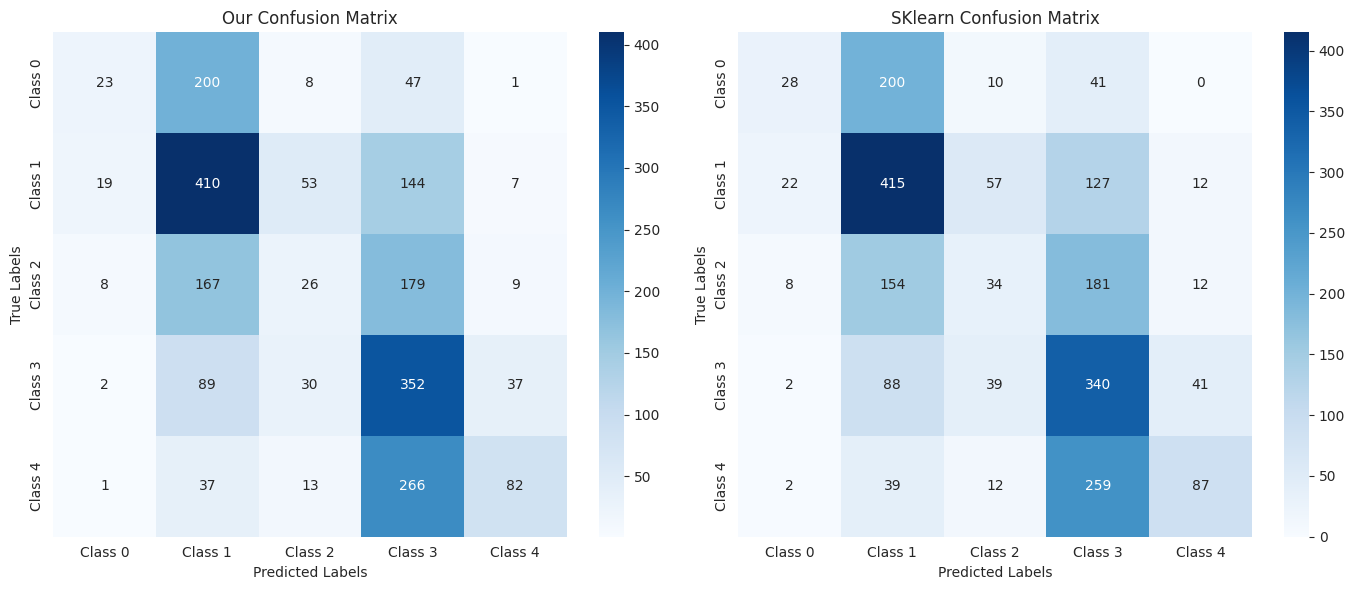

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot the heatmaps side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Heatmap for the first confusion matrix
sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Our Confusion Matrix")
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")

# Heatmap for the second confusion matrix
sns.heatmap(conf_matrix_sk_df, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("SKlearn Confusion Matrix")
axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("True Labels")

plt.tight_layout()
plt.show()

#### Metrics Comparison

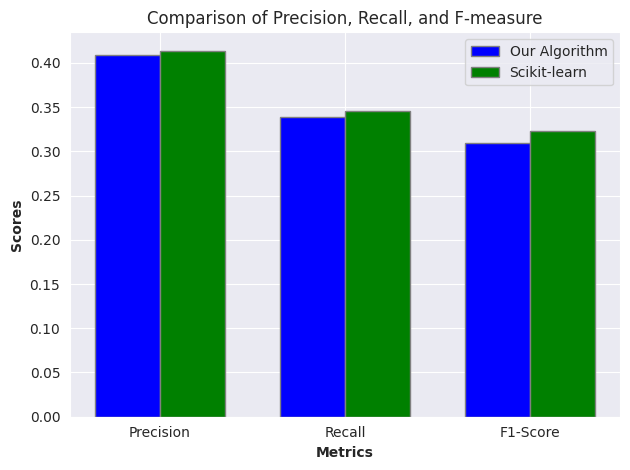

In [43]:
# Data
comparison_metrics = ['Precision', 'Recall', 'F1-Score']
my_algorithm_scores = [metrics.loc[5, 'Precision'], metrics.loc[5, 'Recall'], metrics.loc[5, 'F1-Score']]
sklearn_algorithm_scores = [metrics_sk.loc[5, 'Precision'], metrics_sk.loc[5, 'Recall'], metrics_sk.loc[5, 'F1-Score']]

# Set bar width
bar_width = 0.35

# Set positions of bars on X axis
r1 = np.arange(len(comparison_metrics))  # Our Algorithm
r2 = [x + bar_width for x in r1]  # Scikit-learn Algorithm

# Create bars
plt.bar(r1, my_algorithm_scores, color='b', width=bar_width, edgecolor='grey', label='Our Algorithm')
plt.bar(r2, sklearn_algorithm_scores, color='g', width=bar_width, edgecolor='grey', label='Scikit-learn')

# Add labels
plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.title('Comparison of Precision, Recall, and F-measure')
plt.xticks([r + bar_width / 2 for r in range(len(comparison_metrics))], comparison_metrics)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()